# Bio_ClinicalBERT approach for detecting rare diseases

This notebook contains the code to develop a Bio_ClinicalBERT model to detect rare diseases from texts, which is BERT model pre trained on a huge corpus of medical data (from there, the prefix 'Bio_Clinical').

The Bio_ClinicalBERT model was trained on all notes from [MIMIC III](https://www.nature.com/articles/sdata201635), a database containing electronic health records from ICU patients at the Beth Israel Hospital in Boston, MA. For more details on MIMIC, see [here](https://mimic.physionet.org/). All notes from the NOTEEVENTS table were included (~880M words).

The Bio_ClinicalBERT model was trained using code from [Google's BERT repository](https://github.com/google-research/bert) on a GeForce GTX TITAN X 12 GB GPU. Model parameters were initialized with BioBERT (BioBERT-Base v1.0 + PubMed 200K + PMC 270K).

To accomplish this, we will use some tools developed in the [transformers](https://huggingface.co/transformers/index.html) library, which is a library that recopiles some of the State-of-the-art Natural Language Processing for Pytorch and TensorFlow.

To make use of the pre-trained model with the hugging face `transformers` library, we need the model's weights to be in a form which pyTorch understands. The original model was trained using tensorflow so we need to convert the weights into pyTorch weights. We can then import and use it.

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    #drive.flush_and_unmount()
    drive.mount('/content/drive')
    root = '/content/drive/My Drive/Colab Notebooks'
else:
    print('Not running on CoLab')
    root = './'

print("Current directory: {}".format(root))

Running on CoLab
Mounted at /content/drive
Current directory: /content/drive/My Drive/Colab Notebooks


## 1. Getting the resources

First of all, we will download the model from github repo of [Bio_ClinicalBert](https://github.com/EmilyAlsentzer/clinicalBERT).

After that, we will install the needed packages.

In [ ]:
!pip install pytorch_transformers
!pip install transformers
!pip install seqeval
!pip install sklearn-crfsuite

     |████████████████████████████████| 184kB 7.8MB/s 
     |████████████████████████████████| 901kB 31.6MB/s 
     |████████████████████████████████| 133kB 51.7MB/s 
     |████████████████████████████████| 1.2MB 49.2MB/s 
     |████████████████████████████████| 7.7MB 49.1MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
ERROR: botocore 1.20.107 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.5MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 43.4MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=760903c095388289b9dfe4c6444cb908c6132a6380e28a806dacd46bb164cc19
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
     |████████████████████████████████| 747kB 10.2MB/s 


The pretrained `Bio_ClinicalBERT` model can be obtained both from a direct download [here](https://www.dropbox.com/s/8armk04fu16algz/pretrained_bert_tf.tar.gz?dl=0) or loading it directly from the `transformers library`, which is the way used in this notebook.

## 2. Data loading and first insights

In this step we will download the data and define all of the main paths that our model includes.

It is also possible to select the desired language (`en` for english and `es` for spanish) and whether to consider all the entities from the model or not (`allTypes` variable).

In [ ]:
LANG = 'en'  #This system will also process texts written in Spanish, LANG='es'
allTypes = True
sTypes = ''
if allTypes:
    sTypes = '_all'

#path_data=root+'data/{}/'.format(LANG) #folder where you can find the datasets
path_data = root + '/ner/data/gold_nlp4rare_corpus/' #folder where you can find the datasets
path_models = root + '/ner/models/{}/'.format(LANG) #folder to save the models
checkpoints = root + '/ner/checkpoints/'
path_scores = root + '/ner/scores/{}/'.format(LANG) #folder to save the scores
path_outputs = root + '/ner/outputs/{}/'.format(LANG) #folder to save the scores

print('Datasets:',path_data)
print('Path to save this model:',path_models)
print('Path for checkpoints:',checkpoints)
print('Path to save the scores:',path_scores)
print('Path to save the outputs:',path_outputs)

Datasets: /content/drive/My Drive/Colab Notebooks/ner/data/gold_nlp4rare_corpus/
Path to save this model: /content/drive/My Drive/Colab Notebooks/ner/models/en/
Path for checkpoints: /content/drive/My Drive/Colab Notebooks/ner/checkpoints/
Path to save the scores: /content/drive/My Drive/Colab Notebooks/ner/scores/en/
Path to save the outputs: /content/drive/My Drive/Colab Notebooks/ner/outputs/en/


In [ ]:
import pandas as pd

df_train = pd.read_csv(path_data+'train{}.csv'.format(sTypes),index_col=0)
print('size of the training dataset: {}'.format(len(df_train)))
df_dev = pd.read_csv(path_data+'dev{}.csv'.format(sTypes),index_col=0)
print('size of the development dataset: {}'.format(len(df_dev)))
df_test = pd.read_csv(path_data+'test{}.csv'.format(sTypes),index_col=0)
print('size of the test dataset: {}'.format(len(df_test)))
print('datasets loaded!\n')

#number of labels (IOB tags)
tags = df_train['Tag'].unique()
num_tags = df_train['Tag'].nunique()
print('Labels: {}'.format(tags))
print('Nr of labels: {}'.format(num_tags))

# Overall statistics for the number of words in each text
count_df_train = df_train.groupby('Sentence #').count()
statistics_train = count_df_train['Word'].describe()
print('\nSome statistics of the sentences in the training dataset:')
print(statistics_train)

count_df_dev = df_dev.groupby('Sentence #').count()
statistics_dev = count_df_dev['Word'].describe()
print('\nSome statistics of the sentences in the development dataset:')
print(statistics_dev)

#The lenth of the longest sentence. Lenght is the number of words.
MAX_LEN_TRAIN = int(statistics_train['max'])
MAX_LEN_DEV = int(statistics_dev['max'])
MAX_LEN = max(MAX_LEN_TRAIN, MAX_LEN_DEV)
print('\n')
print('The maximum length of sentences in TRAIN is: ', MAX_LEN_TRAIN)
print('The maximum length of sentences in DEV is: ', MAX_LEN_DEV)
print('The maximum length of sentences in TOTAL is:', MAX_LEN)

size of the training dataset: 135656
size of the development dataset: 18492
size of the test dataset: 37837
datasets loaded!

Labels: ['O' 'B-RAREDISEASE' 'I-RAREDISEASE' 'B-DISEASE' 'I-DISEASE' 'B-SIGN'
 'I-SIGN' 'B-SYMPTOM' 'I-SYMPTOM']
Nr of labels: 9

Some statistics of the sentences in the training dataset:
count    6451.000000
mean       21.028678
std        10.653876
min         1.000000
25%        13.000000
50%        19.000000
75%        26.000000
max        90.000000
Name: Word, dtype: float64

Some statistics of the sentences in the development dataset:
count    903.000000
mean      20.478405
std       10.105284
min        1.000000
25%       13.000000
50%       18.000000
75%       25.000000
max       71.000000
Name: Word, dtype: float64


The maximum length of sentences in TRAIN is:  90
The maximum length of sentences in DEV is:  71
The maximum length of sentences in TOTAL is: 90


We visualize next the distribution of each of the datasets according to its entities.

In [ ]:
separator = '*'*60
# Tag statistics train df
print('TRAIN:\n', df_train['Tag'].value_counts(), sep='\n', end='\n')
print()
print('Percentages:', df_train['Tag'].value_counts(normalize=True)*100, sep='\n', end='\n')

# Tag statistics dev df
print('', separator, '', sep='\n')
print('DEV:\n', df_dev['Tag'].value_counts(), sep='\n', end='\n')
print()
print('Percentages:', df_dev['Tag'].value_counts(normalize=True)*100, sep='\n', end='\n')

# Tag statistics test df
print('', separator, '', sep='\n')
print('TEST:\n', df_test['Tag'].value_counts(), sep='\n', end='\n')
print()
print('Percentages:', df_test['Tag'].value_counts(normalize=True)*100, sep='\n', end='\n')

TRAIN:

O                113555
I-SIGN             7584
I-RAREDISEASE      4116
B-RAREDISEASE      3555
B-SIGN             2914
I-DISEASE          1735
B-DISEASE          1596
I-SYMPTOM           304
B-SYMPTOM           297
Name: Tag, dtype: int64

Percentages:
O                83.708056
I-SIGN            5.590612
I-RAREDISEASE     3.034145
B-RAREDISEASE     2.620599
B-SIGN            2.148080
I-DISEASE         1.278970
B-DISEASE         1.176505
I-SYMPTOM         0.224096
B-SYMPTOM         0.218936
Name: Tag, dtype: float64

************************************************************

DEV:

O                15131
I-SIGN            1337
I-RAREDISEASE      626
B-RAREDISEASE      513
B-SIGN             405
I-DISEASE          224
B-DISEASE          218
I-SYMPTOM           20
B-SYMPTOM           18
Name: Tag, dtype: int64

Percentages:
O                81.824573
I-SIGN            7.230154
I-RAREDISEASE     3.385248
B-RAREDISEASE     2.774173
B-SIGN            2.190136
I-DISEASE         1.

## 3. Imports and pre-processing of the data

First, all the steps to import the necessary packages to use the model are defined. After that, the pre processing of the data is necessary as the `Bert` model need to meet some special requirements.

In [ ]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertForSequenceClassification
from pytorch_pretrained_bert import BertAdam
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 133kB 7.7MB/s 
     |████████████████████████████████| 92kB 7.0MB/s 


'Tesla T4'

The model does not process text, so we need to transform all the pre-defined entities (labels) to a language that can be interpreted by the model, i.e., numbers.

To do that, we create a dictionary with the desired labels following the IOB scheme.

In [ ]:
# We have to create a dictionary for the labels (IOB labels):
# label is key and value is index.
tag_index = {t : i + 1 for i, t in enumerate(tags)}
#we have to add a new label for pad tokens
tag_index["PAD"] = 0

print('Dictionary for labels:', tag_index)
print('Number of tags added the tag for pad tokens:', len(tag_index))

Dictionary for labels: {'O': 1, 'B-RAREDISEASE': 2, 'I-RAREDISEASE': 3, 'B-DISEASE': 4, 'I-DISEASE': 5, 'B-SIGN': 6, 'I-SIGN': 7, 'B-SYMPTOM': 8, 'I-SYMPTOM': 9, 'PAD': 0}
Number of tags added the tag for pad tokens: 10


Next, we perform the first step of preprocessing of the data. Here, a class `SentenceGetter` in combination to a function `vectorization` are defined to extract the desired features from the input data.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class SentenceGetter(object):
    """This is a class to get sentence. Each sentence will be a list of tuples with its words, tag and pos."""
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            #s = self.grouped['Sentence: {}'.format(self.n_sent)]
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

def vectorization(df, tag_index):
    """This functions gets the dataframe with the dataset and transform it to vectors. 
    First, its sentences are retrieved. Then, for each sentence, the function creates a list
    with its corresponding indexes. In addition to X (which are the sentences transformed to vectors),
    the functions also returns the corresponding labels for each token"""
    
    df = df[['Sentence #','Word','POS','Tag']]
    
    # Getting full sentences
    getter = SentenceGetter(df)
    sentences = getter.sentences

    X = [[w[0] for w in s] for s in sentences]

    # Convert label to index
    y = [[tag_index[w[2]] for w in s] for s in sentences]
    
    return (X, y)

# vectorization of datasets
sentences_train, labels_train = vectorization(df_train, tag_index)
sentences_dev, labels_dev = vectorization(df_dev, tag_index)
sentences_test, labels_test = vectorization(df_test, tag_index)
print('Datasets loaded!')

Datasets loaded!


Same as for the labels, all of the retrieved words for each sentence is necessary to be converted to numbers to use them in the model. For that, we use the tokenization of the Bert model.

Afterwards, we also load the model to use as the architecture.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", do_lower_case=True)
model = AutoModelForTokenClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=num_tags+1)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

Here, an example of tokenization is provided to check how this process works.

Through this example, we can see how the original sentence is transformed to new subwords or 'tokens', and after that the tokenizer assign them a number according to its internal vocabulary. 

As new subwords are created, the original lenght of the sentence is modified. Then, the original labels are no longer valid, and a new processing of the labels is necessary to correct this disalignment between words and labels.

In [ ]:
# Example of BERT tokenization
selected_index = np.random.randint(1, 6461)
# selected_index = 344
# selected_index = 4
selected_sentence = sentences_train[selected_index]
tokenized_input = tokenizer(selected_sentence, is_split_into_words=True, add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print("Sentence used: {}\nOriginal sentence:\n\t{}".format(selected_index, selected_sentence))
print("Tokenization of the sentence:\n\t{}".format(tokens))
print('Tokenized ids for the sentence:\n\t{}'.format(tokenized_input["input_ids"]))
print("Length:\n\tOriginal sentence: {}\n\tTokenized sentence: {}\n\tTokenized ids: {}".format(len(selected_sentence), len(tokens), len(tokenized_input["input_ids"])))

# Example label alignment after BERT tokenization
selected_original_labels = labels_train[selected_index]

print('')
print('Original labels:\n\t{}'.format(selected_original_labels))

word_ids = []
index = 0
current_word = ''
for token in tokens:
    if token.startswith("##"):
        word_ids.append(index-1)
    elif token in current_word:
        if len(tokenizer.tokenize(current_word)) != 1:
            subtokens_qty = len(tokenizer.tokenize(current_word))
            for subtoken in tokenizer.tokenize(current_word):
                if token == subtoken:
                    word_ids.append(index-1)
                    break
                subtokens_qty -= 1
                if subtokens_qty == 0:
                    word_ids.append(index)
                    current_word = selected_sentence[index].lower()
                    index += 1
        else:
            word_ids.append(index)
            current_word = selected_sentence[index].lower()
            index += 1
    else:
        word_ids.append(index)
        current_word = selected_sentence[index].lower()
        index += 1

print('New assigned word_ids:\n\t{}'.format(word_ids))

aligned_labels = []
old_index = -1

if allTypes:
    for i in word_ids:
        if (i == old_index) and ( (selected_original_labels[i] == 2) or (selected_original_labels[i] == 4) or (selected_original_labels[i] == 6) or (selected_original_labels[i] == 8) ):
            aligned_labels.append(selected_original_labels[i]+1)
        else:
            aligned_labels.append(selected_original_labels[i])
        old_index = i
else:
    for i in word_ids:
        if (i == old_index) and ( (selected_original_labels[i] == 2) or (selected_original_labels[i] == 4) ):
            aligned_labels.append(selected_original_labels[i]+1)
        else:
            aligned_labels.append(selected_original_labels[i])
        old_index = i

# print('')
# print('Original labels:\n\t{}'.format(selected_original_labels))
# print('New assigned word_ids:\n\t{}'.format(word_ids))
print('New label alignment:\n\t{}'.format(aligned_labels))
print("Length:\n\tOriginal labels: {}\n\tNew assigned word_ids: {}\n\tNew label alignment: {}".format(len(selected_original_labels), len(word_ids), len(aligned_labels)))

Sentence used: 4689
Original sentence:
	['The', 'onset', 'of', 'impaired', 'brain', 'function', 'is', 'rapid', '(', 'acute', ')', ',', 'while', 'other', 'times', 'it', 'can', 'develop', 'slowly', 'over', 'many', 'years', '.']
Tokenization of the sentence:
	['the', 'onset', 'of', 'impaired', 'brain', 'function', 'is', 'rapid', '(', 'acute', ')', ',', 'while', 'other', 'times', 'it', 'can', 'develop', 'slowly', 'over', 'many', 'years', '.']
Tokenized ids for the sentence:
	[1103, 15415, 1104, 20606, 3575, 3053, 1110, 6099, 113, 12104, 114, 117, 1229, 1168, 1551, 1122, 1169, 3689, 2494, 1166, 1242, 1201, 119]
Length:
	Original sentence: 23
	Tokenized sentence: 23
	Tokenized ids: 23

Original labels:
	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
New assigned word_ids:
	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
New label alignment:
	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length:
	Original labels

In [ ]:
# print(tokenizer.tokenize('1%-2'))
# print(tokenizer.tokenize('and'))
# print(tokenizer.tokenize('NMOSD'))
subtoken_to_analyze = '2'
strings = ['1%-2', 'and', 'with', 'NMOSD', '2,000', ',', '2-2', '222', '24-hour']

for string in strings: 
    print('[', string, ']')
    if len(tokenizer.tokenize(string)) != 1:
        print('\t({})'.format(tokenizer.tokenize(string)))
        print('\tnot unique word')
        subtokens_qty = len(tokenizer.tokenize(string))
        for subtoken in tokenizer.tokenize(string):
            if subtoken_to_analyze.lower() == subtoken:
                print('------> <{}> belongs to last word'.format(subtoken_to_analyze))
                break
            subtokens_qty -= 1
            if subtokens_qty == 0:
                print('------> <{}> does NOT belong to last word'.format(subtoken_to_analyze))
    else:
        print('\tunique word')

[ 1%-2 ]
	(['1', '%', '-', '2'])
	not unique word
------> <2> belongs to last word
[ and ]
	unique word
[ with ]
	unique word
[ NMOSD ]
	(['nm', '##os', '##d'])
	not unique word
------> <2> does NOT belong to last word
[ 2,000 ]
	(['2', ',', '000'])
	not unique word
------> <2> belongs to last word
[ , ]
	unique word
[ 2-2 ]
	(['2', '-', '2'])
	not unique word
------> <2> belongs to last word
[ 222 ]
	unique word
[ 24-hour ]
	(['24', '-', 'hour'])
	not unique word
------> <2> does NOT belong to last word


After the example, we proceed with the same operation to the full datasets.

In [ ]:
def align_labels(original_sentences, original_labels, MAX_LEN):
    """
    This function assign the new labels following the original input and according to
    the results from the Tokenization to create a good alignment between words/subwords
    and labels.
    Besides this, it provides the new maximum lenght of the sentences after the Tokenization
    for future padding purposes.
    """
    tokenized_input = tokenizer(original_sentences, is_split_into_words=True, add_special_tokens=False)
    tokens = [tokenizer.convert_ids_to_tokens(t) for t in tokenized_input["input_ids"]]
    list_len = [len(i) for i in tokens]
    MAX_LEN = max(max(list_len), MAX_LEN) 

    word_ids_global = []
    for nr_sentence, list_tokens in enumerate(tokens):
        word_ids = []
        index = 0
        current_word = ''
        for token in list_tokens:
            if token.startswith("##"):
                word_ids.append(index-1)
            elif token in current_word:
                if len(tokenizer.tokenize(current_word)) != 1:
                    subtokens_qty = len(tokenizer.tokenize(current_word))
                    for subtoken in tokenizer.tokenize(current_word):
                        if token == subtoken:
                            word_ids.append(index-1)
                            break
                        subtokens_qty -= 1
                        if subtokens_qty == 0:
                            word_ids.append(index)
                            current_word = original_sentences[nr_sentence][index].lower()
                            index += 1
                else:
                    word_ids.append(index)
                    current_word = original_sentences[nr_sentence][index].lower()
                    index += 1
            else:
                word_ids.append(index)
                current_word = original_sentences[nr_sentence][index].lower()
                index += 1
        word_ids_global.append(word_ids)

    aligned_global = []
    for nr_sentence, list_word_ids in enumerate(word_ids_global):
        aligned_labels = []
        old_index = -1
        if allTypes:
            for i in list_word_ids:
                if (i == old_index) and ( (original_labels[nr_sentence][i] == 2) or (original_labels[nr_sentence][i] == 4) or (original_labels[nr_sentence][i] == 6) or (original_labels[nr_sentence][i] == 8) ):
                    aligned_labels.append(original_labels[nr_sentence][i]+1)
                else:
                    aligned_labels.append(original_labels[nr_sentence][i])
                old_index = i
        else:
            for i in list_word_ids:
                if (i == old_index) and ( (original_labels[nr_sentence][i] == 2) or (original_labels[nr_sentence][i] == 4) ):
                    aligned_labels.append(original_labels[nr_sentence][i]+1)
                else:
                    aligned_labels.append(original_labels[nr_sentence][i])
                old_index = i
        aligned_global.append(aligned_labels)

    return MAX_LEN, aligned_global

print('Aligning labels...')
train_max_len, aligned_labels_train = align_labels(sentences_train, labels_train, MAX_LEN)
dev_max_len, aligned_labels_dev = align_labels(sentences_dev, labels_dev, MAX_LEN)
test_max_len, aligned_labels_test = align_labels(sentences_test, labels_test, MAX_LEN)
print('Labels aligned!')
CORRECTED_MAX_LEN = max(train_max_len, dev_max_len)
print('New defined MAX_LEN after tokenization is: ', CORRECTED_MAX_LEN)

Aligning labels...
Labels aligned!
New defined MAX_LEN after tokenization is:  120


The pre-processing of the data is finished with the padding of the new labels to the maximum lenght and the tokenization of the words.

In [ ]:
# Padding labels according to corrected MAX_LEN
final_train_labels = pad_sequences(maxlen=CORRECTED_MAX_LEN, sequences=aligned_labels_train, padding="post", value=tag_index["PAD"]).tolist()
final_dev_labels = pad_sequences(maxlen=CORRECTED_MAX_LEN, sequences=aligned_labels_dev, padding="post", value=tag_index["PAD"]).tolist()
final_test_labels = pad_sequences(maxlen=CORRECTED_MAX_LEN, sequences=aligned_labels_test, padding="post", value=tag_index["PAD"]).tolist()
print('Labels padded')

# Tokenize inputs according to corrected MAX_LEN
# train dataset
tokenized_input_train = tokenizer(sentences_train, truncation=True, max_length=CORRECTED_MAX_LEN, padding='max_length', is_split_into_words=True, add_special_tokens=False)
print('\nTrain dataset:\n\tsentences lenght: {}.\n\tlabels lenght: {}.\n\tinput_ids length: {}.'.format(len(sentences_train), len(labels_train), len(tokenized_input_train['input_ids'])))

# dev dataset
tokenized_input_dev = tokenizer(sentences_dev, truncation=True, max_length=CORRECTED_MAX_LEN, padding='max_length', is_split_into_words=True, add_special_tokens=False)
print('\nDev dataset:\n\tsentences lenght: {}.\n\tlabels lenght: {}.\n\tinput_ids length: {}.'.format(len(sentences_dev), len(labels_dev), len(tokenized_input_dev['input_ids'])))

# test dataset
tokenized_input_test = tokenizer(sentences_test, truncation=True, max_length=CORRECTED_MAX_LEN, padding='max_length', is_split_into_words=True, add_special_tokens=False)
print('\nTest dataset:\n\tsentences lenght: {}.\n\tlabels lenght: {}.\n\tinput_ids length: {}.'.format(len(sentences_test), len(labels_test), len(tokenized_input_test['input_ids'])))

Labels padded

Train dataset:
	sentences lenght: 6451.
	labels lenght: 6451.
	input_ids length: 6451.

Dev dataset:
	sentences lenght: 903.
	labels lenght: 903.
	input_ids length: 903.

Test dataset:
	sentences lenght: 1772.
	labels lenght: 1772.
	input_ids length: 1772.


We now extract one example from the processed data to check the dimensions and alignment among all of the inputs.

In [ ]:
# Checking all is right
print(tokenized_input_dev.keys())
print(tokenized_input_dev['input_ids'][0])
print(tokenized_input_dev['attention_mask'][0])
print(final_dev_labels[0])
print('Length inputs: {}.\nLength masks: {}.\nLength labels: {}.'.format(len(tokenized_input_dev['input_ids'][0]), len(tokenized_input_dev['attention_mask'][0]), len(final_dev_labels[0])))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[5855, 2552, 9318, 113, 172, 1279, 114, 1110, 170, 4054, 22572, 16071, 22354, 7435, 8936, 1115, 1336, 1129, 10238, 1120, 3485, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 3, 3, 1, 2, 3, 1, 1, 1, 1, 4, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 4. Definition of the model

For reproducibility reasons, we fix a seed for PyTorch and convert all the data into tensors as the model requires.

In [ ]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic=True
batch_size = 32 # 64

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(tokenized_input_train["input_ids"])
train_masks = torch.tensor(tokenized_input_train["attention_mask"])
train_labels = torch.tensor(final_train_labels)

validation_inputs = torch.tensor(tokenized_input_dev["input_ids"])
validation_masks = torch.tensor(tokenized_input_dev["attention_mask"])
validation_labels = torch.tensor(final_dev_labels)

test_inputs = torch.tensor(tokenized_input_test["input_ids"])
test_masks = torch.tensor(tokenized_input_test["attention_mask"])
test_labels = torch.tensor(final_test_labels)

# Checking outputs
print('Train tensor shapes:')
print('Inputs: ', train_inputs.shape)
print('Masks: ', train_masks.shape)
print('Labels: ', train_labels.shape)
print('\nValidation tensor shapes:')
print('Inputs: ', validation_inputs.shape)
print('Masks: ', validation_masks.shape)
print('Labels: ', validation_labels.shape)
print('\nTest tensor shapes:')
print('Inputs: ', test_inputs.shape)
print('Masks: ', test_masks.shape)
print('Labels: ', test_labels.shape)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
shuffled_train_data = torch.utils.data.Subset(train_data, torch.randperm(len(train_data)).tolist())
train_dataloader = DataLoader(shuffled_train_data, batch_size=batch_size, shuffle=False)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
shuffled_validation_data = torch.utils.data.Subset(validation_data, torch.randperm(len(validation_data)).tolist())
validation_dataloader = DataLoader(shuffled_validation_data, batch_size=len(labels_dev), shuffle=False)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
shuffled_test_data = torch.utils.data.Subset(test_data, torch.randperm(len(test_data)).tolist())
test_dataloader = DataLoader(shuffled_test_data, batch_size=len(labels_test), shuffle=False)

Train tensor shapes:
Inputs:  torch.Size([6451, 120])
Masks:  torch.Size([6451, 120])
Labels:  torch.Size([6451, 120])

Validation tensor shapes:
Inputs:  torch.Size([903, 120])
Masks:  torch.Size([903, 120])
Labels:  torch.Size([903, 120])

Test tensor shapes:
Inputs:  torch.Size([1772, 120])
Masks:  torch.Size([1772, 120])
Labels:  torch.Size([1772, 120])


We now charge the model into the cuda core.

In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Here, an example of the evaluation report is provided. For this, we use the `seqeval` library along with the labels or tags we desire to compute.

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
from seqeval.metrics.sequence_labeling import get_entities
from seqeval.metrics import classification_report, accuracy_score
from seqeval.scheme import IOB2


if allTypes:
    tags_metrics = ['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM']
else:
    tags_metrics = ['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-SIGN-SYM', 'I-SIGN-SYM']


# Example of metrics
_labels = final_dev_labels[-10:]
_labels_output = [
        [l for l in sentence if l != 0]
        for sentence in _labels
    ]
_converted = [
        [tags_metrics[l-1] for l in sentence if l != 0]
        for sentence in _labels
    ]
_report = flat_classification_report(y_true=_converted, y_pred=_converted, labels=tags_metrics, digits=4)

print('Tags: {}\nEntities in tag: {}'.format(tags_metrics, get_entities(tags_metrics)))
print()
print('Nr of sentences with labels: {}\nExample of labels: {}\nConverted labels: {}'.format(len(_labels), _labels_output, _converted))
print()
print(_report)

Tags: ['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM']
Entities in tag: [('RAREDISEASE', 1, 2), ('DISEASE', 3, 4), ('SIGN', 5, 6), ('SYMPTOM', 7, 8)]

Nr of sentences with labels: 10
Example of labels: [[2, 3, 3, 3, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1], [1, 1, 1, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1], [2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
Converted labels: [['B-RAREDISEASE', 'I-RAREDISEASE', 'I-RAR

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5. Fine tuning the model and training

Finally, we define the model parameters and hyper parameters and its training.

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to compute the metrics of our predictions vs labels
def flat_accuracy(predictions, labels):
    """
    This function computes the accuracy of the network as a float number.
    """
    pred_flat = np.argmax(predictions, axis=2).flatten()
    labels_flat = labels.flatten()
    valid_predictions = [tags_metrics[p-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]
    valid_flags = [tags_metrics[l-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]
    return accuracy_score(y_true=valid_flags, y_pred=valid_predictions)

# Function to calculate the accuracy of our predictions vs labels
def compute_nn_metrics(predictions, labels, tags=tags_metrics, entity_level=False, imbalanced=False):
    """
    This function computes the metrics of the network through the seqeval model.
    """
    pred_flat = np.argmax(predictions, axis=2).flatten()
    labels_flat = labels.flatten()
    imbalanced_tags = [t for t in tags]
    imbalanced_tags.remove('O')
    valid_predictions = [[tags_metrics[p-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]]
    valid_flags = [[tags_metrics[l-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]]
    if entity_level:
        return classification_report(y_true=valid_flags, y_pred=valid_predictions, scheme=IOB2, zero_division=0, digits=4)
    else:
        if imbalanced:
            return flat_classification_report(y_true=valid_flags, y_pred=valid_predictions, labels=imbalanced_tags, zero_division=0, digits=4)
        else:
            return flat_classification_report(y_true=valid_flags, y_pred=valid_predictions, labels=tags, zero_division=0, digits=4)
        

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
eval_accuracy_set = []
# Number of training epochs 
epochs = 9

print('Model finetuned!\nNr of epochs to use: {}'.format(epochs))

t_total value of -1 results in schedule not being applied


Model finetuned!
Nr of epochs to use: 9


In [ ]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
    ## TRAINING

    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss, train_accuracy = 0, 0
    nb_train_steps = 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        train_loss_set.append(loss.item())   
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        tr_loss += loss.item()
        nb_train_steps += 1
    print("\nTrain loss: {}".format(tr_loss/nb_train_steps))
    print("Total Train Accuracy: {}".format(train_accuracy/nb_train_steps))

    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_accuracy = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_metrics = compute_nn_metrics(logits, label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy   
        eval_accuracy_set.append(tmp_eval_accuracy)    
        nb_eval_steps += 1
    print('\nMetrics report in Validation:\n{}'.format(eval_metrics))
    print("Total Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)



Train loss: 0.48225549033077636
Total Train Accuracy: 0.849661863728547


Epoch:  11%|█         | 1/9 [02:29<19:59, 149.97s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9582    0.9490    0.9536     16744
B-RAREDISEASE     0.8179    0.8928    0.8537       513
I-RAREDISEASE     0.8643    0.9309    0.8964      2156
    B-DISEASE     0.6851    0.5688    0.6216       218
    I-DISEASE     0.6258    0.6370    0.6313       617
       B-SIGN     0.6202    0.7136    0.6636       405
       I-SIGN     0.6921    0.6790    0.6855      2165
    B-SYMPTOM     0.3333    0.1111    0.1667        18
    I-SYMPTOM     0.4000    0.0500    0.0889        40

     accuracy                         0.9020     22876
    macro avg     0.6663    0.6147    0.6179     22876
 weighted avg     0.9020    0.9020    0.9014     22876

Total Validation Accuracy: 0.9020370694177303

Train loss: 0.19841337012182367
Total Train Accuracy: 0.9317131282208388


Epoch:  22%|██▏       | 2/9 [05:03<17:36, 150.93s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9626    0.9465    0.9545     16744
B-RAREDISEASE     0.8422    0.8947    0.8677       513
I-RAREDISEASE     0.8539    0.9569    0.9024      2156
    B-DISEASE     0.6940    0.5826    0.6334       218
    I-DISEASE     0.6538    0.6029    0.6273       617
       B-SIGN     0.6659    0.7086    0.6866       405
       I-SIGN     0.6921    0.7122    0.7020      2165
    B-SYMPTOM     0.5333    0.4444    0.4848        18
    I-SYMPTOM     0.5769    0.3750    0.4545        40

     accuracy                         0.9058     22876
    macro avg     0.7194    0.6915    0.7015     22876
 weighted avg     0.9069    0.9058    0.9059     22876

Total Validation Accuracy: 0.905796467913971

Train loss: 0.12566399443341364
Total Train Accuracy: 0.9580176960206326


Epoch:  33%|███▎      | 3/9 [07:35<15:08, 151.45s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9485    0.9642    0.9563     16744
B-RAREDISEASE     0.8315    0.8850    0.8574       513
I-RAREDISEASE     0.8716    0.9443    0.9065      2156
    B-DISEASE     0.7727    0.5459    0.6398       218
    I-DISEASE     0.7685    0.5219    0.6216       617
       B-SIGN     0.7172    0.6889    0.7028       405
       I-SIGN     0.7336    0.6600    0.6949      2165
    B-SYMPTOM     0.4286    0.6667    0.5217        18
    I-SYMPTOM     0.4571    0.4000    0.4267        40

     accuracy                         0.9098     22876
    macro avg     0.7255    0.6974    0.7031     22876
 weighted avg     0.9064    0.9098    0.9069     22876

Total Validation Accuracy: 0.9097744360902256

Train loss: 0.09603618726244953
Total Train Accuracy: 0.9688730296397038


Epoch:  44%|████▍     | 4/9 [10:08<12:39, 151.81s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9488    0.9656    0.9571     16744
B-RAREDISEASE     0.8371    0.8616    0.8492       513
I-RAREDISEASE     0.8792    0.9249    0.9014      2156
    B-DISEASE     0.6320    0.7248    0.6752       218
    I-DISEASE     0.5961    0.6888    0.6391       617
       B-SIGN     0.7209    0.6123    0.6622       405
       I-SIGN     0.7685    0.5949    0.6707      2165
    B-SYMPTOM     0.3846    0.5556    0.4545        18
    I-SYMPTOM     0.5000    0.3750    0.4286        40

     accuracy                         0.9070     22876
    macro avg     0.6964    0.7004    0.6931     22876
 weighted avg     0.9049    0.9070    0.9045     22876

Total Validation Accuracy: 0.9069767441860465

Train loss: 0.0719164134012443
Total Train Accuracy: 0.9770630889320866


Epoch:  56%|█████▌    | 5/9 [12:40<10:08, 152.01s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9607    0.9544    0.9575     16744
B-RAREDISEASE     0.8660    0.8441    0.8549       513
I-RAREDISEASE     0.8960    0.8873    0.8916      2156
    B-DISEASE     0.6113    0.7431    0.6708       218
    I-DISEASE     0.5651    0.7455    0.6429       617
       B-SIGN     0.6699    0.6914    0.6804       405
       I-SIGN     0.7202    0.6776    0.6982      2165
    B-SYMPTOM     0.4333    0.7222    0.5417        18
    I-SYMPTOM     0.4186    0.4500    0.4337        40

     accuracy                         0.9060     22876
    macro avg     0.6823    0.7462    0.7080     22876
 weighted avg     0.9092    0.9060    0.9071     22876

Total Validation Accuracy: 0.9060150375939849

Train loss: 0.05488448727548602
Total Train Accuracy: 0.9832241923860782


Epoch:  67%|██████▋   | 6/9 [15:13<07:36, 152.31s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9574    0.9576    0.9575     16744
B-RAREDISEASE     0.8447    0.8694    0.8569       513
I-RAREDISEASE     0.8913    0.9207    0.9058      2156
    B-DISEASE     0.6726    0.6972    0.6847       218
    I-DISEASE     0.6369    0.7277    0.6793       617
       B-SIGN     0.6958    0.7284    0.7117       405
       I-SIGN     0.7354    0.6674    0.6998      2165
    B-SYMPTOM     0.5714    0.6667    0.6154        18
    I-SYMPTOM     0.5455    0.4500    0.4932        40

     accuracy                         0.9108     22876
    macro avg     0.7279    0.7428    0.7338     22876
 weighted avg     0.9106    0.9108    0.9104     22876

Total Validation Accuracy: 0.9108235705542927

Train loss: 0.03980383536856769
Total Train Accuracy: 0.9880101382845751


Epoch:  78%|███████▊  | 7/9 [17:46<05:04, 152.36s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9571    0.9602    0.9587     16744
B-RAREDISEASE     0.8512    0.8811    0.8659       513
I-RAREDISEASE     0.8917    0.9239    0.9075      2156
    B-DISEASE     0.6824    0.7294    0.7051       218
    I-DISEASE     0.6481    0.7164    0.6805       617
       B-SIGN     0.7086    0.7086    0.7086       405
       I-SIGN     0.7612    0.6771    0.7167      2165
    B-SYMPTOM     0.4615    0.6667    0.5455        18
    I-SYMPTOM     0.4390    0.4500    0.4444        40

     accuracy                         0.9139     22876
    macro avg     0.7112    0.7459    0.7259     22876
 weighted avg     0.9134    0.9139    0.9133     22876

Total Validation Accuracy: 0.9138835460744885

Train loss: 0.035036253974551686
Total Train Accuracy: 0.9890102884069549


Epoch:  89%|████████▉ | 8/9 [20:18<02:32, 152.40s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9534    0.9621    0.9577     16744
B-RAREDISEASE     0.8675    0.8421    0.8546       513
I-RAREDISEASE     0.9044    0.8998    0.9021      2156
    B-DISEASE     0.6639    0.7339    0.6972       218
    I-DISEASE     0.6270    0.7164    0.6687       617
       B-SIGN     0.6790    0.7259    0.7017       405
       I-SIGN     0.7447    0.6550    0.6970      2165
    B-SYMPTOM     0.5238    0.6111    0.5641        18
    I-SYMPTOM     0.5625    0.4500    0.5000        40

     accuracy                         0.9103     22876
    macro avg     0.7251    0.7329    0.7270     22876
 weighted avg     0.9096    0.9103    0.9096     22876

Total Validation Accuracy: 0.9102990033222591

Train loss: 0.029837808019071266
Total Train Accuracy: 0.9912476429657326


Epoch: 100%|██████████| 9/9 [22:51<00:00, 152.41s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9468    0.9695    0.9580     16744
B-RAREDISEASE     0.8569    0.8635    0.8602       513
I-RAREDISEASE     0.8930    0.9174    0.9051      2156
    B-DISEASE     0.6916    0.7202    0.7056       218
    I-DISEASE     0.6677    0.7099    0.6881       617
       B-SIGN     0.7363    0.6963    0.7157       405
       I-SIGN     0.7915    0.6102    0.6891      2165
    B-SYMPTOM     0.4643    0.7222    0.5652        18
    I-SYMPTOM     0.5143    0.4500    0.4800        40

     accuracy                         0.9129     22876
    macro avg     0.7291    0.7399    0.7297     22876
 weighted avg     0.9102    0.9129    0.9103     22876

Total Validation Accuracy: 0.912921839482427


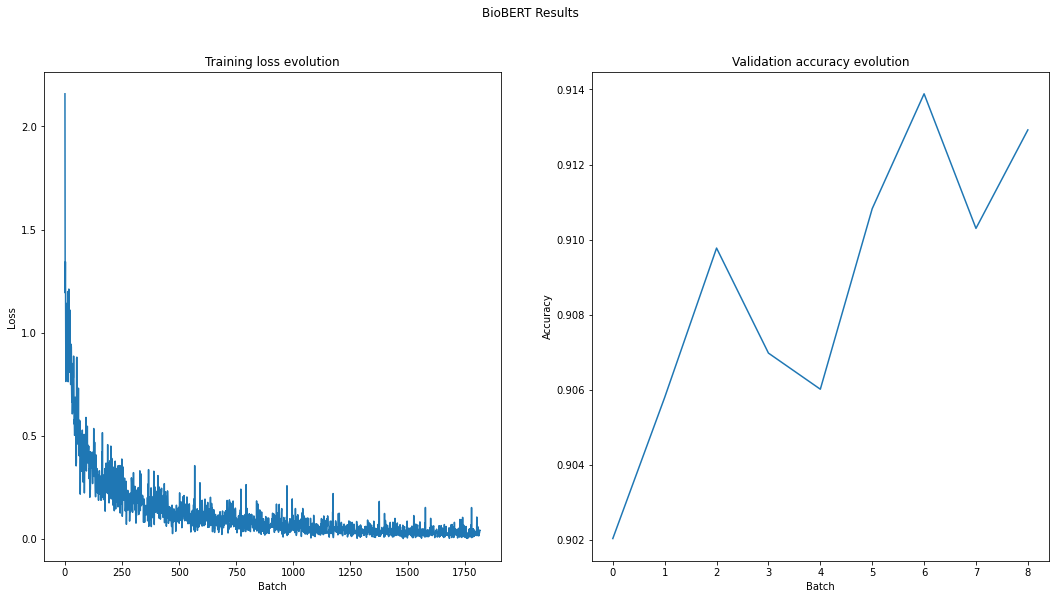

In [ ]:
# plot training performance
results_figure = plt.figure(figsize=(18,9))
ax_train = results_figure.add_subplot(1, 2, 1)
ax_val = results_figure.add_subplot(1, 2, 2)
results_figure.suptitle('BioBERT Results')
ax_train.set_title("Training loss evolution")
ax_train.set_xlabel("Batch")
ax_train.set_ylabel("Loss")
ax_train.plot(train_loss_set)
ax_val.set_title("Validation accuracy evolution")
ax_val.set_xlabel("Batch")
ax_val.set_ylabel("Accuracy")
ax_val.plot(eval_accuracy_set)
plt.show()

## 6. Testing the model

The final step is to test the model. This step is similar to the evaluation one with the difference that the input dataset is changed.

In [ ]:
## TEST

# Put model in evaluation mode
model.eval()
# Evaluate data for one epoch
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits   
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    test_metrics = compute_nn_metrics(logits, label_ids)
    test_metrics_imbalanced = compute_nn_metrics(logits, label_ids, imbalanced=True)
    test_metrics_per_entity = compute_nn_metrics(logits, label_ids, entity_level=True)
print('Metrics report in Test (with "O" class):\n{}'.format(test_metrics))
print('Metrics report in Test (w/o "O" class):\n{}'.format(test_metrics_imbalanced))
print('Metrics report in Test per entity:\n{}'.format(test_metrics_per_entity))

Metrics report in Test (with "O" class):
               precision    recall  f1-score   support

            O     0.9579    0.9691    0.9635     35108
B-RAREDISEASE     0.8614    0.8807    0.8710      1073
I-RAREDISEASE     0.8829    0.9076    0.8951      4370
    B-DISEASE     0.6503    0.6885    0.6689       443
    I-DISEASE     0.5969    0.6557    0.6249      1278
       B-SIGN     0.6996    0.6961    0.6979       803
       I-SIGN     0.7575    0.6220    0.6831      3762
    B-SYMPTOM     0.7547    0.8000    0.7767        50
    I-SYMPTOM     0.7158    0.5231    0.6044       130

     accuracy                         0.9163     47017
    macro avg     0.7641    0.7492    0.7539     47017
 weighted avg     0.9147    0.9163    0.9149     47017

Metrics report in Test (w/o "O" class):
               precision    recall  f1-score   support

B-RAREDISEASE     0.8614    0.8807    0.8710      1073
I-RAREDISEASE     0.8829    0.9076    0.8951      4370
    B-DISEASE     0.6503    0.6885 

Scenarios:

    - I. Surface string and entity type match
    - II. System hypothesized an entity
    - III. System misses an entity
    - IV. System assigns the wrong entity type
    - V. System gets the boundaries of the surface string wrong
    - VI. System gets the boundaries and entity type wrong

MUC metrics:

    - Correct (COR) : both are the same
    - Incorrect (INC) : the output of a system and the golden annotation don’t match
    - Partial (PAR) : system and the golden annotation are somewhat “similar” but not the same
    - Missing (MIS) : a golden annotation is not captured by a system
    - Spurius (SPU) : system produces a response which doesn’t exist in the golden annotation

Four different ways to measure precision/recall/f1-score:

    - Strict: exact boundary surface string match and entity type
    - Exact: exact boundary match over the surface string, regardless of the type
    - Partial: partial boundary match over the surface string, regardless of the type
    - Type: some overlap between the system tagged entity and the gold annotation is required


In [ ]:
import logging
from collections import namedtuple
from copy import deepcopy

logging.basicConfig(
    format="%(asctime)s %(name)s %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="DEBUG",
)

Entity = namedtuple("Entity", "e_type start_offset end_offset")

class Evaluator():

    def __init__(self, true, pred, tags):
        """
        """

        if len(true) != len(pred):
            raise ValueError("Number of predicted documents does not equal true")

        self.true = true
        self.pred = pred
        self.tags = tags

        # Setup dict into which metrics will be stored.

        self.metrics_results = {
            'correct': 0,
            'incorrect': 0,
            'partial': 0,
            'missed': 0,
            'spurious': 0,
            'possible': 0,
            'actual': 0,
            'precision': 0,
            'recall': 0,
        }

        # Copy results dict to cover the four schemes.

        self.results = {
            'strict': deepcopy(self.metrics_results),
            'ent_type': deepcopy(self.metrics_results),
            'partial':deepcopy(self.metrics_results),
            'exact':deepcopy(self.metrics_results),
            }

        # Create an accumulator to store results

        self.evaluation_agg_entities_type = {e: deepcopy(self.results) for e in tags}


    def evaluate(self):

        logging.info(
            "Imported %s predictions for %s true examples",
            len(self.pred), len(self.true)
        )

        for true_ents, pred_ents in zip(self.true, self.pred):

            # Check that the length of the true and predicted examples are the
            # same. This must be checked here, because another error may not
            # be thrown if the lengths do not match.

            if len(true_ents) != len(pred_ents):
                raise ValueError("Prediction length does not match true example length")

            # Compute results for one message

            tmp_results, tmp_agg_results = compute_metrics(
                collect_named_entities(true_ents),
                collect_named_entities(pred_ents),
                self.tags
            )

            # Cycle through each result and accumulate

            # TODO: Combine these loops below:

            for eval_schema in self.results:

                for metric in self.results[eval_schema]:

                    self.results[eval_schema][metric] += tmp_results[eval_schema][metric]

            # Calculate global precision and recall

            self.results = compute_precision_recall_wrapper(self.results)

            # Aggregate results by entity type

            for e_type in self.tags:

                for eval_schema in tmp_agg_results[e_type]:

                    for metric in tmp_agg_results[e_type][eval_schema]:

                        self.evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

                # Calculate precision recall at the individual entity level

                self.evaluation_agg_entities_type[e_type] = compute_precision_recall_wrapper(self.evaluation_agg_entities_type[e_type])

        return self.results, self.evaluation_agg_entities_type


def collect_named_entities(tokens):
    """
    Creates a list of Entity named-tuples, storing the entity type and the start and end
    offsets of the entity.
    :param tokens: a list of tags
    :return: a list of Entity named-tuples
    """

    named_entities = []
    start_offset = None
    end_offset = None
    ent_type = None

    for offset, token_tag in enumerate(tokens):

        if token_tag == 'O':
            if ent_type is not None and start_offset is not None:
                end_offset = offset - 1
                named_entities.append(Entity(ent_type, start_offset, end_offset))
                start_offset = None
                end_offset = None
                ent_type = None

        elif ent_type is None:
            ent_type = token_tag[2:]
            start_offset = offset

        elif ent_type != token_tag[2:] or (ent_type == token_tag[2:] and token_tag[:1] == 'B'):

            end_offset = offset - 1
            named_entities.append(Entity(ent_type, start_offset, end_offset))

            # start of a new entity
            ent_type = token_tag[2:]
            start_offset = offset
            end_offset = None

    # catches an entity that goes up until the last token

    if ent_type is not None and start_offset is not None and end_offset is None:
        named_entities.append(Entity(ent_type, start_offset, len(tokens)-1))

    return named_entities


def compute_metrics(true_named_entities, pred_named_entities, tags):


    eval_metrics = {'correct': 0, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'precision': 0, 'recall': 0}

    # overall results
    
    evaluation = {
        'strict': deepcopy(eval_metrics),
        'ent_type': deepcopy(eval_metrics),
        'partial': deepcopy(eval_metrics),
        'exact': deepcopy(eval_metrics)
    }

    # results by entity type

    evaluation_agg_entities_type = {e: deepcopy(evaluation) for e in tags}

    # keep track of entities that overlapped

    true_which_overlapped_with_pred = []

    # Subset into only the tags that we are interested in.
    # NOTE: we remove the tags we don't want from both the predicted and the
    # true entities. This covers the two cases where mismatches can occur:
    #
    # 1) Where the model predicts a tag that is not present in the true data
    # 2) Where there is a tag in the true data that the model is not capable of
    # predicting.

    true_named_entities = [ent for ent in true_named_entities if ent.e_type in tags]
    pred_named_entities = [ent for ent in pred_named_entities if ent.e_type in tags]

    # go through each predicted named-entity

    for pred in pred_named_entities:
        found_overlap = False

        # Check each of the potential scenarios in turn. See
        # http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/
        # for scenario explanation.

        # Scenario I: Exact match between true and pred

        if pred in true_named_entities:
            true_which_overlapped_with_pred.append(pred)
            evaluation['strict']['correct'] += 1
            evaluation['ent_type']['correct'] += 1
            evaluation['exact']['correct'] += 1
            evaluation['partial']['correct'] += 1

            # for the agg. by e_type results
            evaluation_agg_entities_type[pred.e_type]['strict']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['ent_type']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['exact']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['partial']['correct'] += 1

        else:

            # check for overlaps with any of the true entities

            for true in true_named_entities:

                pred_range = range(pred.start_offset, pred.end_offset)
                true_range = range(true.start_offset, true.end_offset)

                # Scenario IV: Offsets match, but entity type is wrong

                if true.start_offset == pred.start_offset and pred.end_offset == true.end_offset \
                        and true.e_type != pred.e_type:

                    # overall results
                    evaluation['strict']['incorrect'] += 1
                    evaluation['ent_type']['incorrect'] += 1
                    evaluation['partial']['correct'] += 1
                    evaluation['exact']['correct'] += 1

                    # aggregated by entity type results
                    evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                    evaluation_agg_entities_type[true.e_type]['ent_type']['incorrect'] += 1
                    evaluation_agg_entities_type[true.e_type]['partial']['correct'] += 1
                    evaluation_agg_entities_type[true.e_type]['exact']['correct'] += 1

                    true_which_overlapped_with_pred.append(true)
                    found_overlap = True

                    break

                # check for an overlap i.e. not exact boundary match, with true entities

                elif find_overlap(true_range, pred_range):

                    true_which_overlapped_with_pred.append(true)

                    # Scenario V: There is an overlap (but offsets do not match
                    # exactly), and the entity type is the same.
                    # 2.1 overlaps with the same entity type

                    if pred.e_type == true.e_type:

                        # overall results
                        evaluation['strict']['incorrect'] += 1
                        evaluation['ent_type']['correct'] += 1
                        evaluation['partial']['partial'] += 1
                        evaluation['exact']['incorrect'] += 1

                        # aggregated by entity type results
                        evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['ent_type']['correct'] += 1
                        evaluation_agg_entities_type[true.e_type]['partial']['partial'] += 1
                        evaluation_agg_entities_type[true.e_type]['exact']['incorrect'] += 1

                        found_overlap = True

                        break

                    # Scenario VI: Entities overlap, but the entity type is
                    # different.

                    else:
                        # overall results
                        evaluation['strict']['incorrect'] += 1
                        evaluation['ent_type']['incorrect'] += 1
                        evaluation['partial']['partial'] += 1
                        evaluation['exact']['incorrect'] += 1

                        # aggregated by entity type results
                        # Results against the true entity

                        evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['partial']['partial'] += 1
                        evaluation_agg_entities_type[true.e_type]['ent_type']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['exact']['incorrect'] += 1

                        # Results against the predicted entity

                        # evaluation_agg_entities_type[pred.e_type]['strict']['spurious'] += 1

                        found_overlap = True

                        break

            # Scenario II: Entities are spurious (i.e., over-generated).

            if not found_overlap:

                # Overall results

                evaluation['strict']['spurious'] += 1
                evaluation['ent_type']['spurious'] += 1
                evaluation['partial']['spurious'] += 1
                evaluation['exact']['spurious'] += 1

                # Aggregated by entity type results

                # NOTE: when pred.e_type is not found in tags
                # or when it simply does not appear in the test set, then it is
                # spurious, but it is not clear where to assign it at the tag
                # level. In this case, it is applied to all target_tags
                # found in this example. This will mean that the sum of the
                # evaluation_agg_entities will not equal evaluation.

                for true in tags:                    

                    evaluation_agg_entities_type[true]['strict']['spurious'] += 1
                    evaluation_agg_entities_type[true]['ent_type']['spurious'] += 1
                    evaluation_agg_entities_type[true]['partial']['spurious'] += 1
                    evaluation_agg_entities_type[true]['exact']['spurious'] += 1

    # Scenario III: Entity was missed entirely.

    for true in true_named_entities:
        if true in true_which_overlapped_with_pred:
            continue
        else:
            # overall results
            evaluation['strict']['missed'] += 1
            evaluation['ent_type']['missed'] += 1
            evaluation['partial']['missed'] += 1
            evaluation['exact']['missed'] += 1

            # for the agg. by e_type
            evaluation_agg_entities_type[true.e_type]['strict']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['ent_type']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['partial']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['exact']['missed'] += 1

    # Compute 'possible', 'actual' according to SemEval-2013 Task 9.1 on the
    # overall results, and use these to calculate precision and recall.

    for eval_type in evaluation:
        evaluation[eval_type] = compute_actual_possible(evaluation[eval_type])

    # Compute 'possible', 'actual', and precision and recall on entity level
    # results. Start by cycling through the accumulated results.

    for entity_type, entity_level in evaluation_agg_entities_type.items():

        # Cycle through the evaluation types for each dict containing entity
        # level results.

        for eval_type in entity_level:

            evaluation_agg_entities_type[entity_type][eval_type] = compute_actual_possible(
                entity_level[eval_type]
            )

    return evaluation, evaluation_agg_entities_type


def find_overlap(true_range, pred_range):
    """Find the overlap between two ranges
    Find the overlap between two ranges. Return the overlapping values if
    present, else return an empty set().
    Examples:
    >>> find_overlap((1, 2), (2, 3))
    2
    >>> find_overlap((1, 2), (3, 4))
    set()
    """

    true_set = set(true_range)
    pred_set = set(pred_range)

    overlaps = true_set.intersection(pred_set)

    return overlaps


def compute_actual_possible(results):
    """
    Takes a result dict that has been output by compute metrics.
    Returns the results dict with actual, possible populated.
    When the results dicts is from partial or ent_type metrics, then
    partial_or_type=True to ensure the right calculation is used for
    calculating precision and recall.
    """

    correct = results['correct']
    incorrect = results['incorrect']
    partial = results['partial']
    missed = results['missed']
    spurious = results['spurious']

    # Possible: number annotations in the gold-standard which contribute to the
    # final score

    possible = correct + incorrect + partial + missed

    # Actual: number of annotations produced by the NER system

    actual = correct + incorrect + partial + spurious

    results["actual"] = actual
    results["possible"] = possible

    return results


def compute_precision_recall(results, partial_or_type=False):
    """
    Takes a result dict that has been output by compute metrics.
    Returns the results dict with precison and recall populated.
    When the results dicts is from partial or ent_type metrics, then
    partial_or_type=True to ensure the right calculation is used for
    calculating precision and recall.
    """

    actual = results["actual"]
    possible = results["possible"]
    partial = results['partial']
    correct = results['correct']

    if partial_or_type:
        precision = (correct + 0.5 * partial) / actual if actual > 0 else 0
        recall = (correct + 0.5 * partial) / possible if possible > 0 else 0

    else:
        precision = correct / actual if actual > 0 else 0
        recall = correct / possible if possible > 0 else 0

    results["precision"] = precision
    results["recall"] = recall

    return results


def compute_precision_recall_wrapper(results):
    """
    Wraps the compute_precision_recall function and runs on a dict of results
    """

    results_a = {key: compute_precision_recall(value, True) for key, value in results.items() if
                 key in ['partial', 'ent_type']}
    results_b = {key: compute_precision_recall(value) for key, value in results.items() if
                 key in ['strict', 'exact']}

    results = {**results_a, **results_b}

    return results

In [ ]:
inputs_idxs = b_input_ids.to('cpu').numpy()
inputs_idxs = [[i for i in sentence if i != 0] for sentence in inputs_idxs]
inputs_idxs = [tokenizer.convert_ids_to_tokens(sentence) for sentence in inputs_idxs]
pred_flat = np.argmax(logits, axis=2)
pred_sym = [[tags_metrics[l-1] for l in sentence if l != 0] for sentence in pred_flat]
true_flags = [[tags_metrics[l-1] for l in sentence if l != 0] for sentence in label_ids]
pred_flags = []

for sp, st in zip(pred_sym, true_flags):
    limit = len(st)
    new = sp[:limit]
    pred_flags.append(new)

print('Labels and sentences created')

Labels and sentences created


In [ ]:
import random

random.seed(3)
result_examples_idx = random.sample(range(len(true_flags)), k=30)
result_examples_y_gold = list()
result_examples_y_pred = list()
original_sentences = list()

for idx in result_examples_idx:
    result_examples_y_gold.append(true_flags[idx])
    result_examples_y_pred.append(pred_flags[idx])
    original_sentences.append(inputs_idxs[idx])

itr = 0
for g, p, s in zip(result_examples_y_gold, result_examples_y_pred, original_sentences):
    assert len(g) == len(p), 'Results does not seem to be the same'
    print('Sentence Nr: ', result_examples_idx[itr])
    original_s = pd.Series(s, name='WORD')
    df = pd.DataFrame(original_s)
    df['GOLD'] = g
    df['PRED'] = p
    print(df)
    itr += 1
    print()

Sentence Nr:  487
        WORD           GOLD           PRED
0        the              O              O
1      major              O              O
2   physical              O              O
3   features              O              O
4         of              O              O
5         ad  B-RAREDISEASE  B-RAREDISEASE
6      ##ams  I-RAREDISEASE  I-RAREDISEASE
7          -  I-RAREDISEASE  I-RAREDISEASE
8      olive  I-RAREDISEASE  I-RAREDISEASE
9        ##r  I-RAREDISEASE  I-RAREDISEASE
10  syndrome  I-RAREDISEASE  I-RAREDISEASE
11         (              O              O
12         i              O              O
13         .              O              O
14         e              O              O
15         .              O              O
16         ,              O              O
17     scalp         B-SIGN         B-SIGN
18   defects         I-SIGN         I-SIGN
19       and              O              O
20      limb              O         B-SIGN
21  abnormal              O         

In [ ]:
if allTypes:
    test_labels = ['DISEASE', 'RAREDISEASE', 'SYMPTOM', 'SIGN']
else:
    test_labels = ['RAREDISEASE', 'SIGN-SYM']

test_to_use_gold = result_examples_y_gold
test_to_use_pred = result_examples_y_pred

evaluator_examples = Evaluator(test_to_use_gold, test_to_use_pred, test_labels)
results_examples, results_agg_examples = evaluator_examples.evaluate()

print('## OVERALL RESULTS')
for item in results_examples.keys():
    print('\tEvaluation Metric: ', item)
    print('\t', results_examples[item])
print('## RESULTS AT ENTITY LEVEL')
for entity in results_agg_examples.keys():
    print('Entity: ', entity)
    for item in results_agg_examples[entity].keys():
        print('\tEvaluation Metric: ', item)
        print('\t', results_agg_examples[entity][item])

2021-07-08 16:54:03 root INFO: Imported 30 predictions for 30 true examples


## OVERALL RESULTS
	Evaluation Metric:  ent_type
	 {'correct': 28, 'incorrect': 3, 'partial': 0, 'missed': 6, 'spurious': 6, 'possible': 37, 'actual': 37, 'precision': 0.7567567567567568, 'recall': 0.7567567567567568}
	Evaluation Metric:  partial
	 {'correct': 26, 'incorrect': 0, 'partial': 5, 'missed': 6, 'spurious': 6, 'possible': 37, 'actual': 37, 'precision': 0.7702702702702703, 'recall': 0.7702702702702703}
	Evaluation Metric:  strict
	 {'correct': 24, 'incorrect': 7, 'partial': 0, 'missed': 6, 'spurious': 6, 'possible': 37, 'actual': 37, 'precision': 0.6486486486486487, 'recall': 0.6486486486486487}
	Evaluation Metric:  exact
	 {'correct': 26, 'incorrect': 5, 'partial': 0, 'missed': 6, 'spurious': 6, 'possible': 37, 'actual': 37, 'precision': 0.7027027027027027, 'recall': 0.7027027027027027}
## RESULTS AT ENTITY LEVEL
Entity:  DISEASE
	Evaluation Metric:  ent_type
	 {'correct': 6, 'incorrect': 2, 'partial': 0, 'missed': 0, 'spurious': 6, 'possible': 8, 'actual': 14, 'precision': 

In [ ]:
evaluator_all = Evaluator(true_flags, pred_flags, test_labels)
results_all, results_agg_all = evaluator_all.evaluate()

print('## OVERALL RESULTS')
for item in results_all.keys():
    print('\tEvaluation Metric: ', item)
    print('\t', results_all[item])
print('## RESULTS AT ENTITY LEVEL')
for entity in results_agg_all.keys():
    print('Entity: ', entity)
    for item in results_agg_all[entity].keys():
        print('\tEvaluation Metric: ', item)
        print('\t', results_agg_all[entity][item])

2021-07-08 16:54:03 root INFO: Imported 1772 predictions for 1772 true examples


## OVERALL RESULTS
	Evaluation Metric:  ent_type
	 {'correct': 2026, 'incorrect': 276, 'partial': 0, 'missed': 306, 'spurious': 406, 'possible': 2608, 'actual': 2708, 'precision': 0.7481536189069424, 'recall': 0.776840490797546}
	Evaluation Metric:  partial
	 {'correct': 2018, 'incorrect': 0, 'partial': 284, 'missed': 306, 'spurious': 406, 'possible': 2608, 'actual': 2708, 'precision': 0.7976366322008862, 'recall': 0.8282208588957055}
	Evaluation Metric:  strict
	 {'correct': 1794, 'incorrect': 508, 'partial': 0, 'missed': 306, 'spurious': 406, 'possible': 2608, 'actual': 2708, 'precision': 0.6624815361890695, 'recall': 0.6878834355828221}
	Evaluation Metric:  exact
	 {'correct': 2018, 'incorrect': 284, 'partial': 0, 'missed': 306, 'spurious': 406, 'possible': 2608, 'actual': 2708, 'precision': 0.7451994091580503, 'recall': 0.7737730061349694}
## RESULTS AT ENTITY LEVEL
Entity:  DISEASE
	Evaluation Metric:  ent_type
	 {'correct': 308, 'incorrect': 109, 'partial': 0, 'missed': 39, 'spur